# Problem Statement

Our objective is to explore the viability of employing a Machine Learning model for the implementation of Predictive Maintenance on turbofan engines. We will work under the assumption that the following insights have been gathered through discussions with the turbofan engine's operating company:

* Flexible Maintenance Schedule: The maintenance schedule for the turbofan engines is adaptable and can be adjusted as needed. This adaptability is crucial for our analysis to be effective.

* Long-Term Value Generation: The analysis we undertake is expected to yield substantial long-term value for the company operating the turbofan engines.

Given the established points above, our focal point now shifts to the analytical aspect. We will harness sensor data to create a predictive model that can estimate the Remaining Useful Life (RUL) of the turbofan engines. This RUL prediction can then be harnessed to enable the implementation of predictive maintenance practices.


# Dataset

Engine degradation simulation was conducted using the C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) framework. Specifically, we focused on one of the simulated sets, namely FD001 as it is least complex.

Training trajectories encompass data from 100 distinct engines, while the test trajectories involve an additional set of 100 engines. The focus is placed on a single fault mode. The datasets encapsulate simulations spanning various turbofan engines over a duration, with each row of data encompassing the subsequent details:

1. Engine unit number
2. Time elapsed, measured in cycles
3. Three distinct operational configurations
4. 21 recorded sensor measurements

Notably, specific details concerning the types of sensors, such as pressure sensors, temperature sensors, vibration sensors, etc., have not been provided. Incorporating such sensor-specific knowledge could potentially yield deeper insights into engine degradation through domain expertise.













# Importing Libraries and dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading and Visualizing the Dataset

In [ ]:
# Defining column names

index_names = ['unit_num','time(cycles)']
setting_names = ['setting_1','setting_2','setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] # This list comprehension generates column names for the sensor readings
col_names = index_names + setting_names + sensor_names # This combines all the defined column names into a single list, creating a complete set of column names for the data.

# Reading the data

train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names = col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None,names=col_names)
y_test = pd.read_csv('RUL_FD001.txt',sep='\s+', header=None,names=['RUL'])

The above code defines column names for different data components (engine unit, time, operational settings, sensor readings), reads data from three separate files ('train_FD001.txt', 'test_FD001.txt', and 'RUL_FD001.txt'), and loads the data into pandas DataFrames with appropriate column names.

In [ ]:
train.head()

unit_num  time(cycles)  setting_1  setting_2  setting_3     s_1     s_2  \
0         1             1    -0.0007    -0.0004      100.0  518.67  641.82   
1         1             2     0.0019    -0.0003      100.0  518.67  642.15   
2         1             3    -0.0043     0.0003      100.0  518.67  642.35   
3         1             4     0.0007     0.0000      100.0  518.67  642.35   
4         1             5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  23.4190  
1  2388  100.0  39.00  23.4236  
2  2388  100.0  38.95  23.3442  
3  2388  100.0  38.88  23.3739  
4  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

In [ ]:
train.shape

(20631, 26)

In [ ]:
test.head()

unit_num  time(cycles)  setting_1  setting_2  setting_3     s_1     s_2  \
0         1             1     0.0023     0.0003      100.0  518.67  643.02   
1         1             2    -0.0027    -0.0003      100.0  518.67  641.71   
2         1             3     0.0003     0.0001      100.0  518.67  642.46   
3         1             4     0.0042     0.0000      100.0  518.67  642.44   
4         1             5     0.0014     0.0000      100.0  518.67  642.51   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1585.29  1398.21  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03   392   
1  1588.45  1395.42  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03   393   
2  1586.94  1401.34  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03   393   
3  1584.12  1406.42  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03   391   
4  1587.19  1401.92  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03   390   

   s_18   s_19   s_20     s_21  
0  2388  100.0  38.86  23.3735  
1  2388  100.0  39.02  23.3916  
2  2388  100.0  39.08  23.4166  
3  2388  100.0  39.00  23.3737  
4  2388  100.0  38.99  23.4130  

[5 rows x 26 columns]

In [ ]:
test.shape

(13096, 26)

• For Test dataset, since the true RUL values for the test set are only provided for the last time cycle of each engine, dataset has to be subsetted to represent the same.

In [ ]:
test = test.groupby('unit_num').last().reset_index().drop(['unit_num','time(cycles)'],axis=1)

The above code snippet takes the 'test' DataFrame, groups its data by unique engine 'unit_num' values, retains only the last row of data for each engine (representing the final time cycle), resets the index, and removes the 'unit_num' and 'time(cycles)' columns. The end result is a DataFrame containing only the operational setting and sensor reading columns for the last time cycle of each engine.

In [ ]:
test.head()

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0    -0.0006     0.0004      100.0  518.67  642.58  1581.22  1398.91  14.62   
1     0.0018    -0.0001      100.0  518.67  642.55  1586.59  1410.83  14.62   
2    -0.0016     0.0004      100.0  518.67  642.88  1589.75  1418.89  14.62   
3     0.0012     0.0004      100.0  518.67  642.78  1594.53  1406.88  14.62   
4    -0.0013    -0.0004      100.0  518.67  642.27  1589.94  1419.36  14.62   

     s_6     s_7  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0  21.61  554.42  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388   
1  21.61  553.52  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388   
2  21.61  552.59  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388   
3  21.61  552.64  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388   
4  21.61  553.29  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388   

    s_19   s_20     s_21  
0  100.0  38.81  23.3552  
1  100.0  38.81  23.2618  
2  100.0  38.93  23.2740  
3  100.0  38.58  23.2581  
4  100.0  38.75  23.4117  

[5 rows x 24 columns]

# Descriptive Statistics

In [ ]:
# Inspecting unit_num

train[index_names].describe()

unit_num  time(cycles)
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

In [ ]:
# Inspecting the time

train[index_names].groupby('unit_num').max().describe()

time(cycles)
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000

In [ ]:
# Inspecting the settings

train[setting_names].describe()

setting_1     setting_2  setting_3
count  20631.000000  20631.000000    20631.0
mean      -0.000009      0.000002      100.0
std        0.002187      0.000293        0.0
min       -0.008700     -0.000600      100.0
25%       -0.001500     -0.000200      100.0
50%        0.000000      0.000000      100.0
75%        0.001500      0.000300      100.0
max        0.008700      0.000600      100.0

In [ ]:
# Inspecting sensor values

train[sensor_names].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

# Computing Remaining Useful Life (RUL)

In [ ]:
def find_remaining_useful_life(df):

    # Getting the total number of cycles for each unit
    grouped_by_unit = df.groupby('unit_num') # groups the input DataFrame 'df' by the 'unit_num' column
    max_cycle = grouped_by_unit['time(cycles)'].max() # calculates the maximum value of the 'time(cycles)' column within each grouped unit.

    # Merging the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'),left_on='unit_num',right_index=True)

    # Calculating remaining useful life for each row
    remaining_useful_life = result_frame['max_cycle'] - result_frame['time(cycles)']
    result_frame['RUL'] = remaining_useful_life

    # Dropping max_cycle as it is no longer needed after calculating RUL.
    result_frame = result_frame.drop('max_cycle',axis=1)
    return result_frame

train = find_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_num  time(cycles)  RUL
0         1             1  191
1         1             2  190
2         1             3  189
3         1             4  188
4         1             5  187

# Exploratory Data Analysis (EDA)

## Distribution of Remaining Useful Life (RUL)

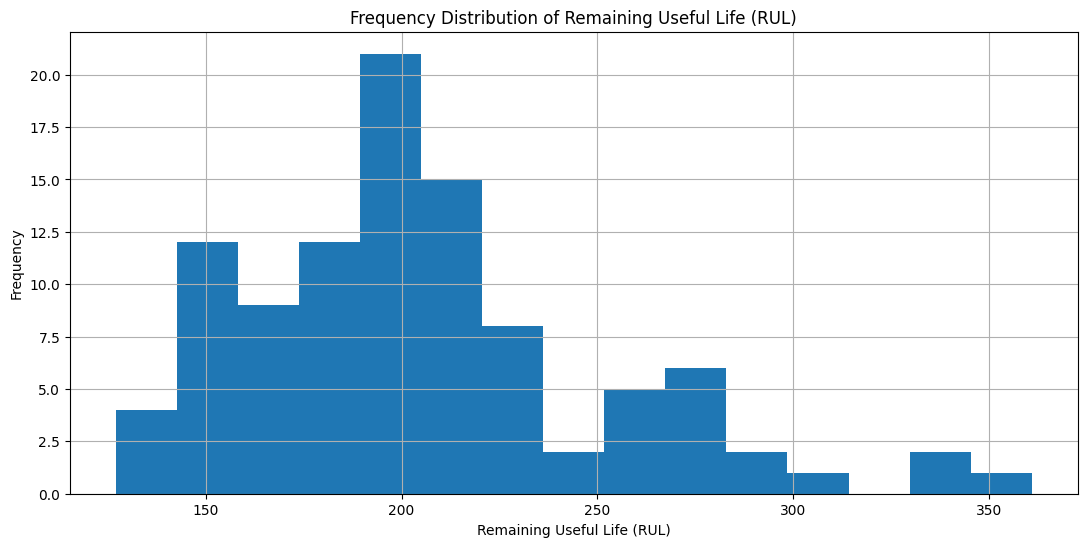

In [ ]:
df_max_rul = train[['unit_num','RUL']].groupby('unit_num').max().reset_index()
df_max_rul['RUL'].hist(bins=15,figsize=(13,6))
plt.title('Frequency Distribution of Remaining Useful Life (RUL)')
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.show()

The graph indicates that the Remaining Useful Life (RUL) distribution for engines is skewed to the left. This could imply that a significant portion of the engines have relatively low remaining lifetimes, indicating that they might fail or require maintenance sooner.

## Boxplot of Remaining Useful Life (RUL)

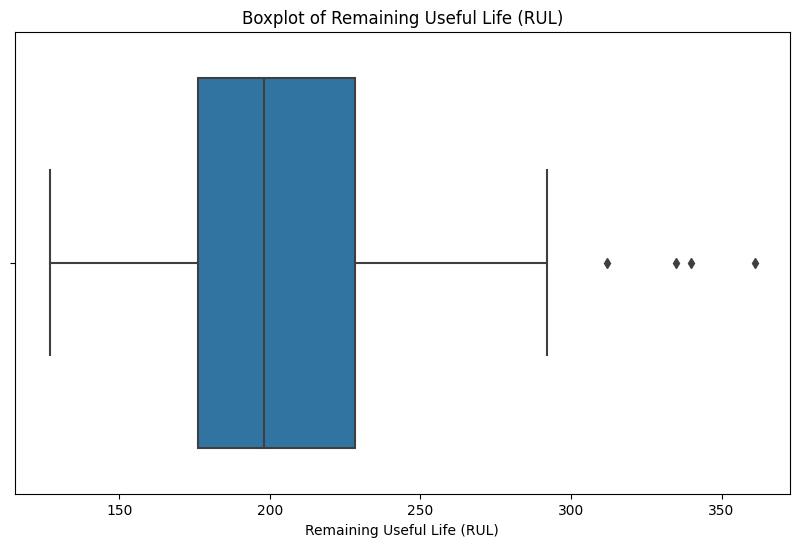

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_max_rul['RUL'])
plt.title('Boxplot of Remaining Useful Life (RUL)')
plt.xlabel('Remaining Useful Life (RUL)')
plt.show()

The boxplot shows that the RUL distribution for the turbofan engine is slightly left-skewed. This means that there are more engines with a short RUL than there are engines with a long RUL.

## Quantile of Remaining Useful Life (RUL)

In [ ]:
# Checking how RUL values are distributed into various quantiles.
train['RUL'].quantile([.1, .25, .5, .75,0.9])

0.10     20.0
0.25     51.0
0.50    103.0
0.75    155.0
0.90    198.0
Name: RUL, dtype: float64

• Quantile charts shows that 10 % of total engines have RUL of 20 or below , 25% of total engines have RUL of 51 or below, 50% of total engines have RUL of 103 or below, 75% of total engines have RUL of 155 or below and 90 % of total engines have RUL of 198 or below.

## Sensors vs Remaining Useful Life (RUL)

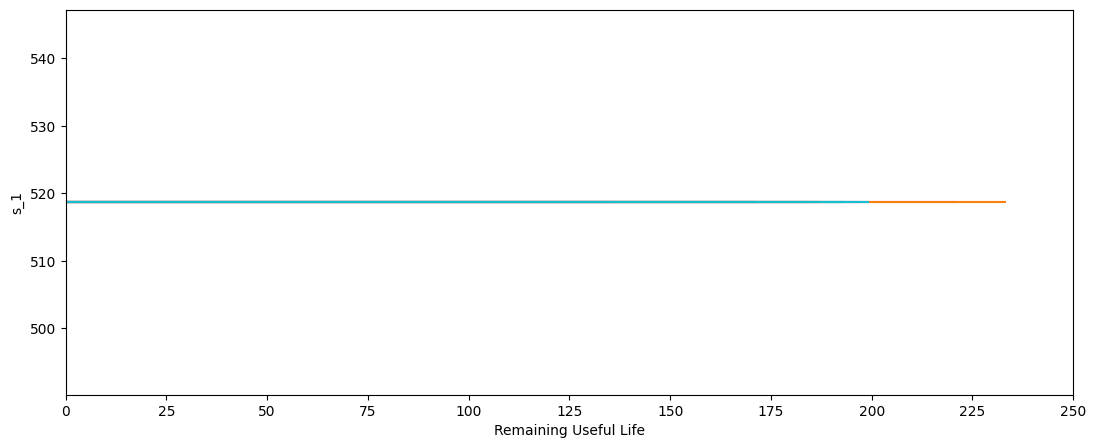

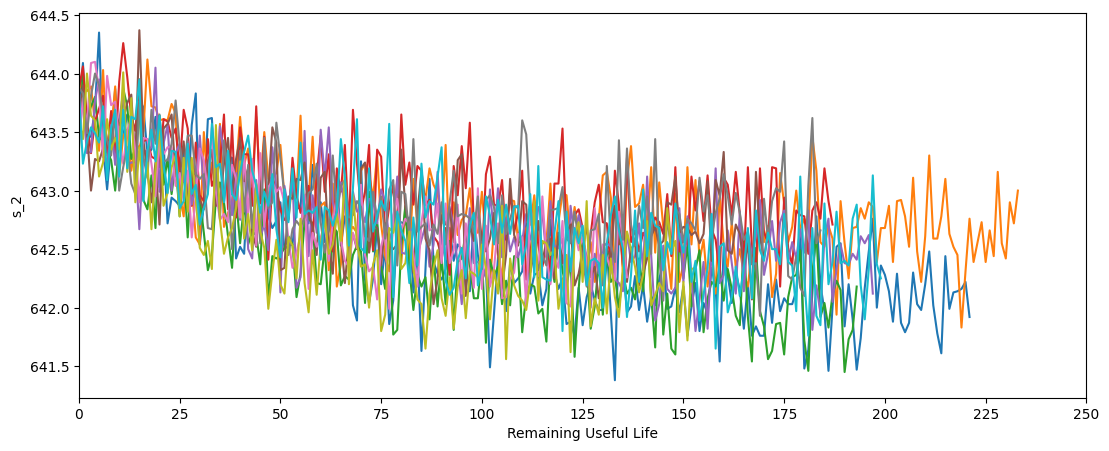

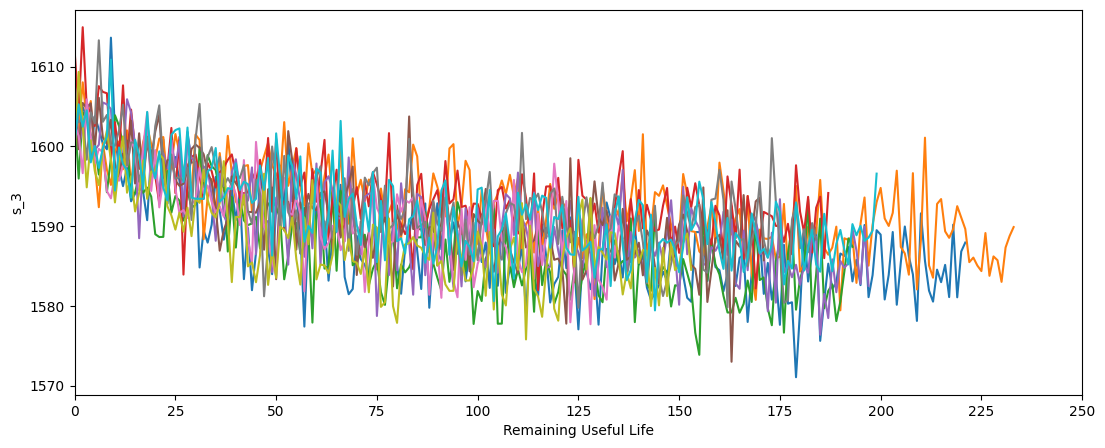

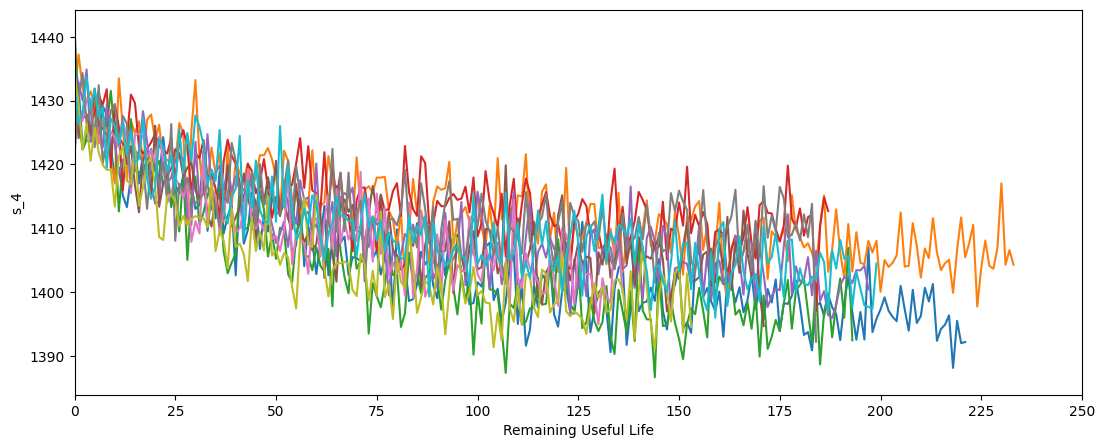

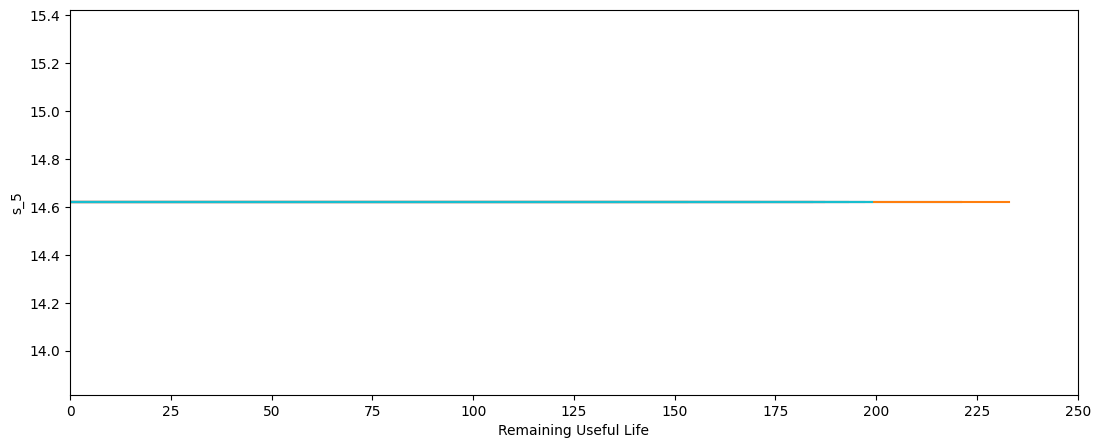

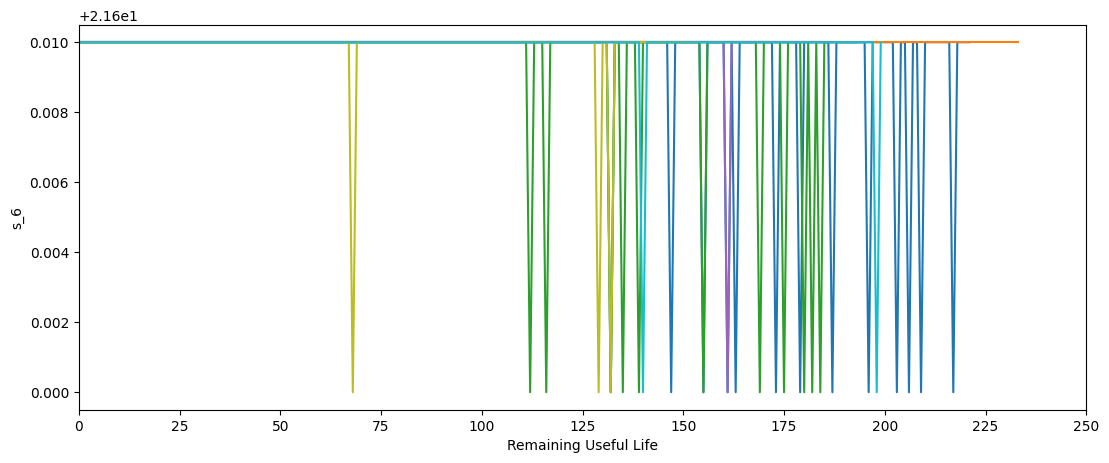

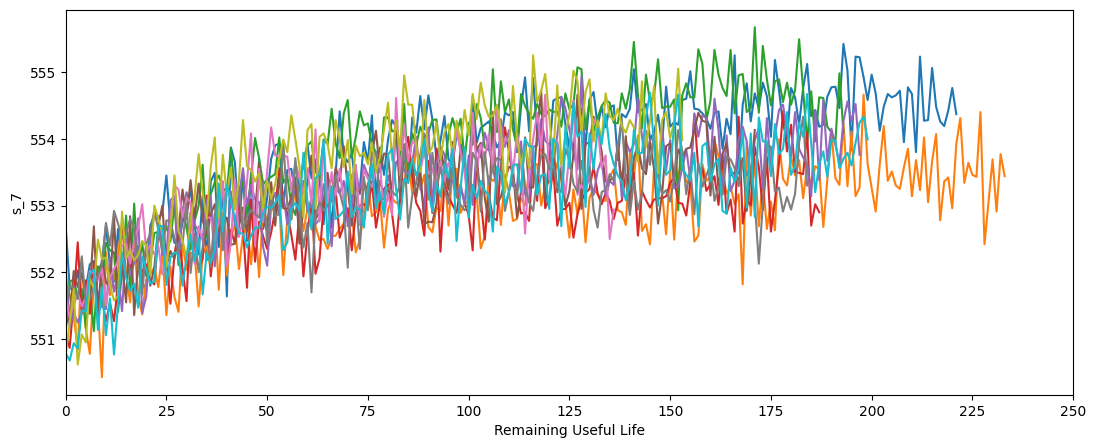

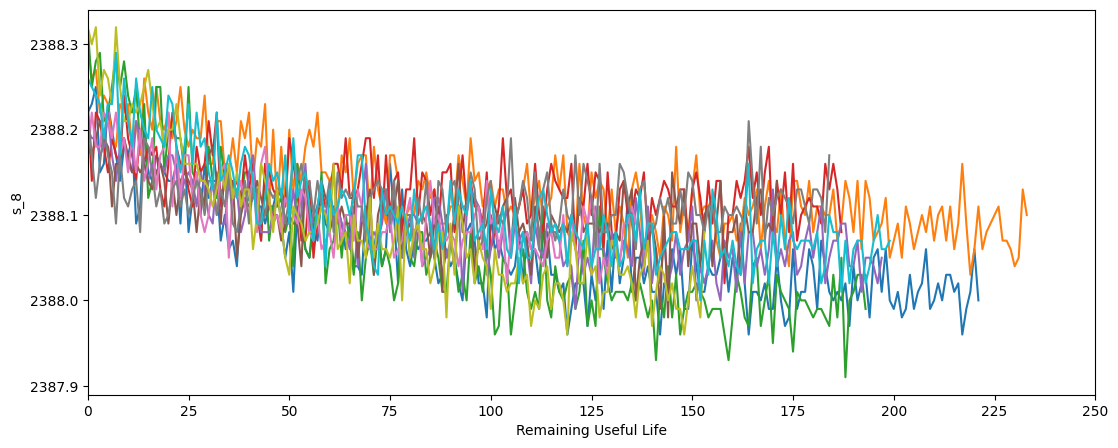

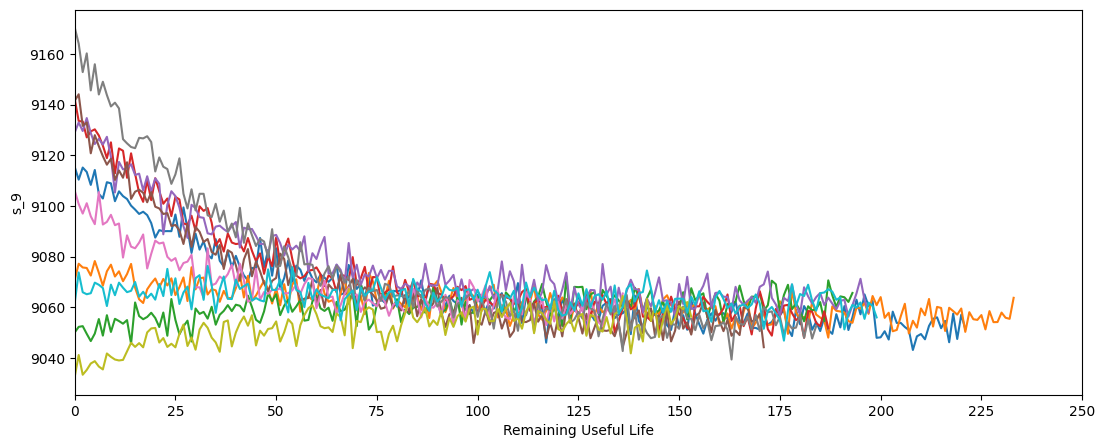

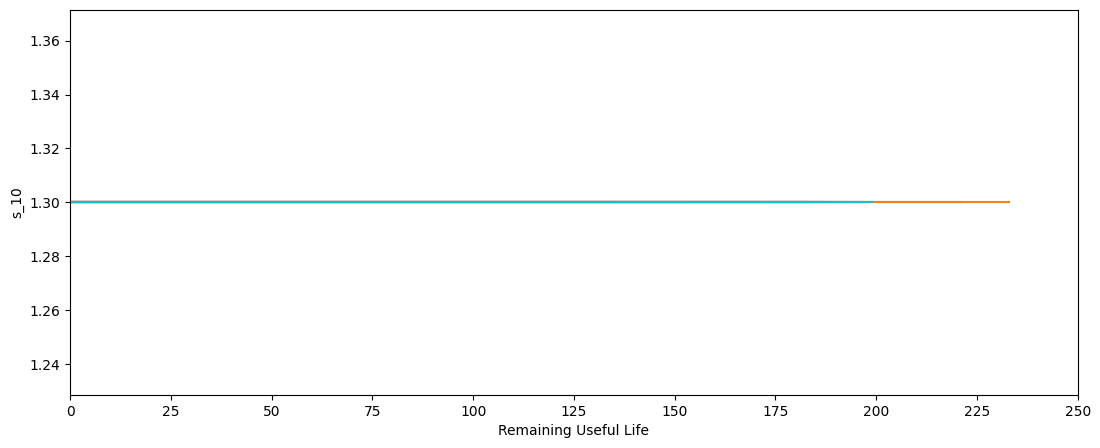

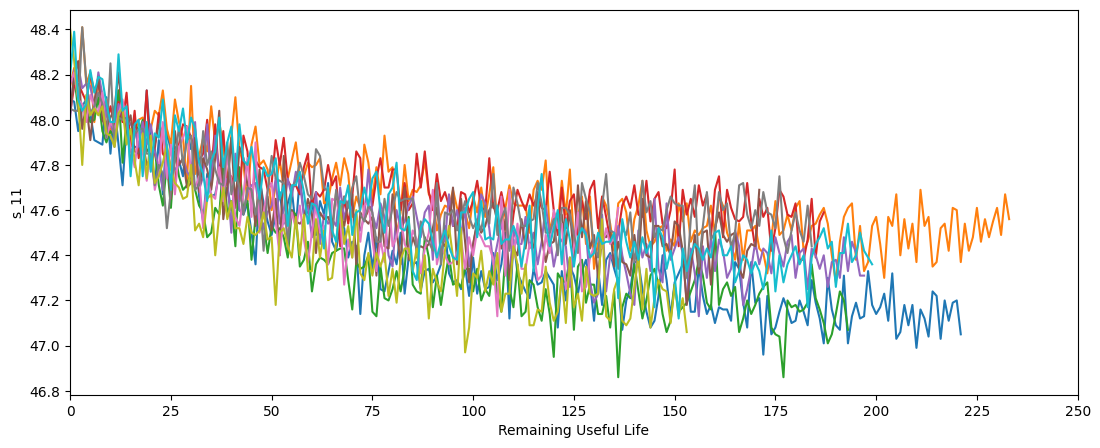

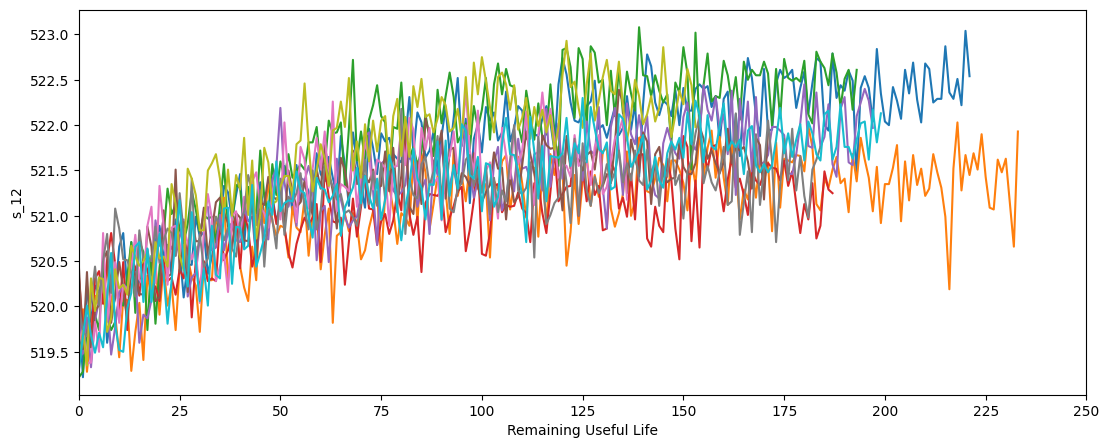

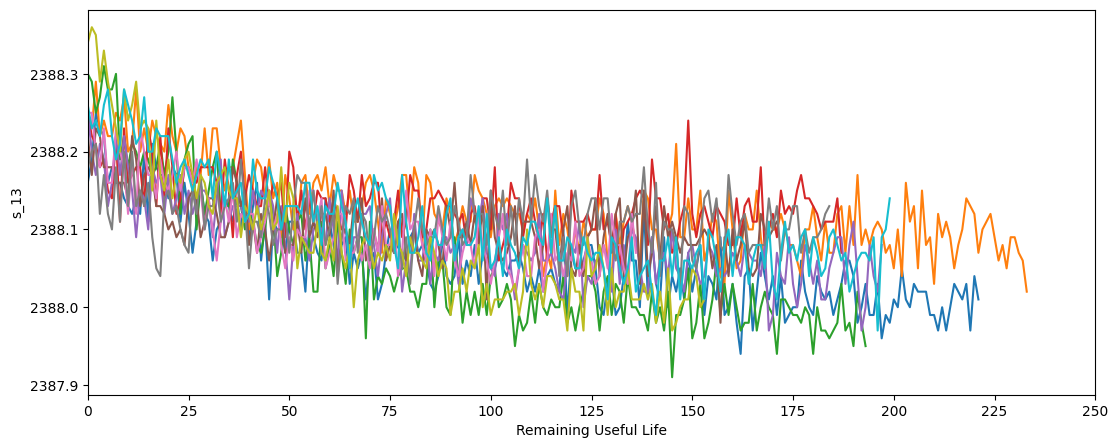

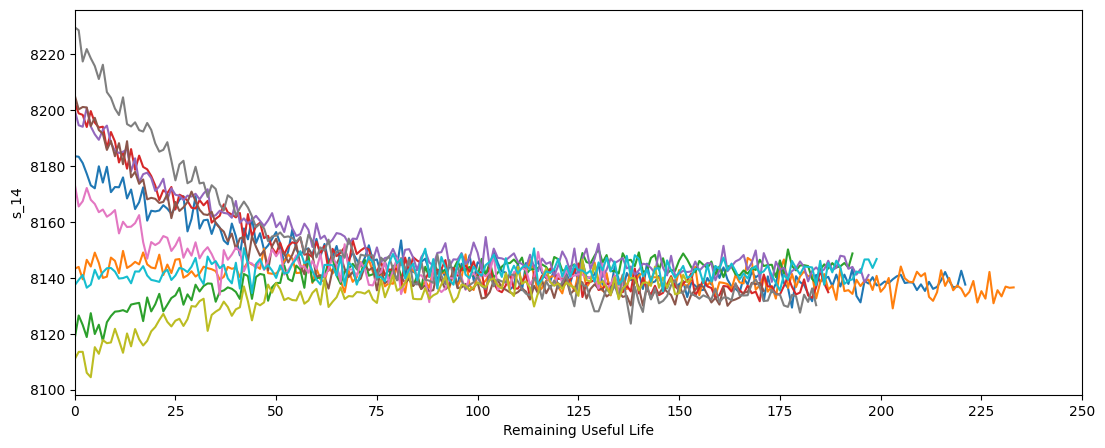

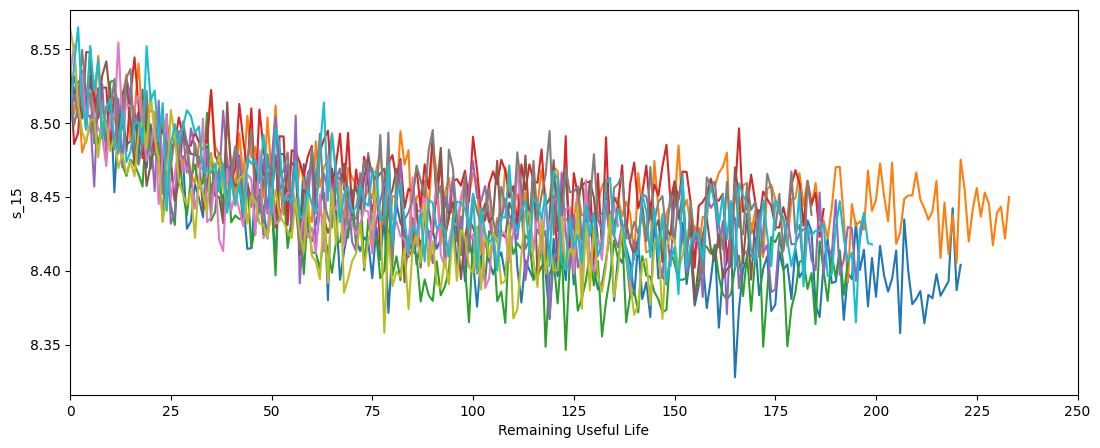

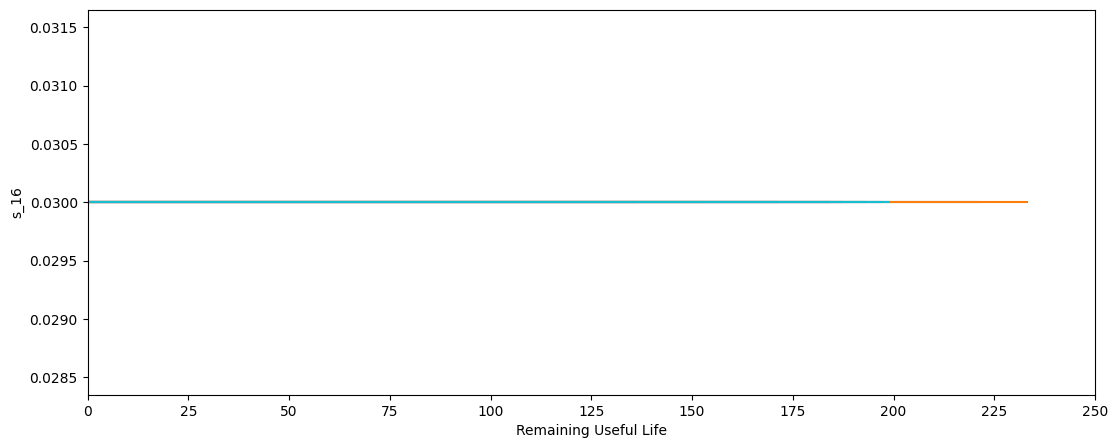

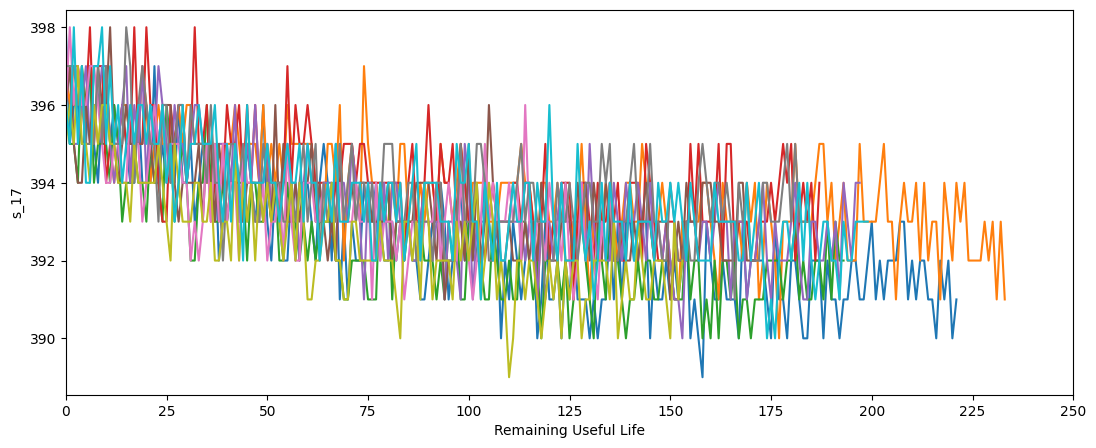

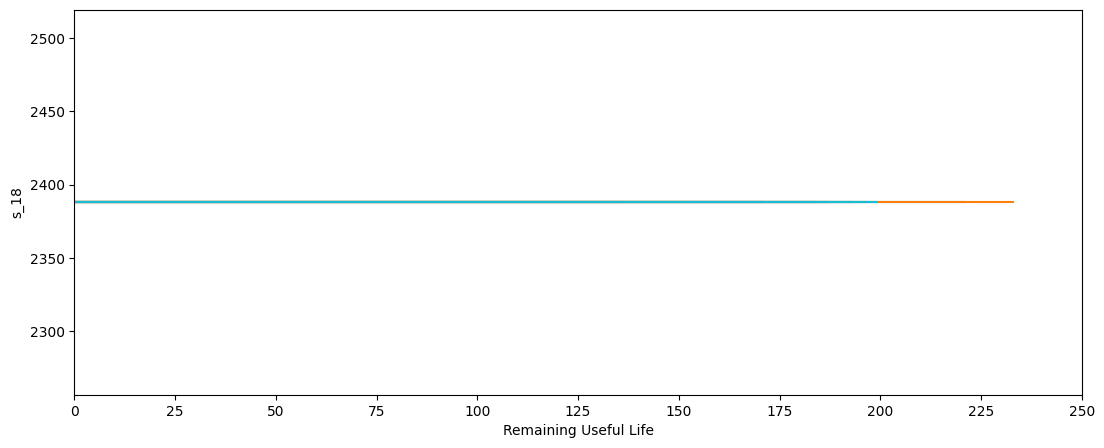

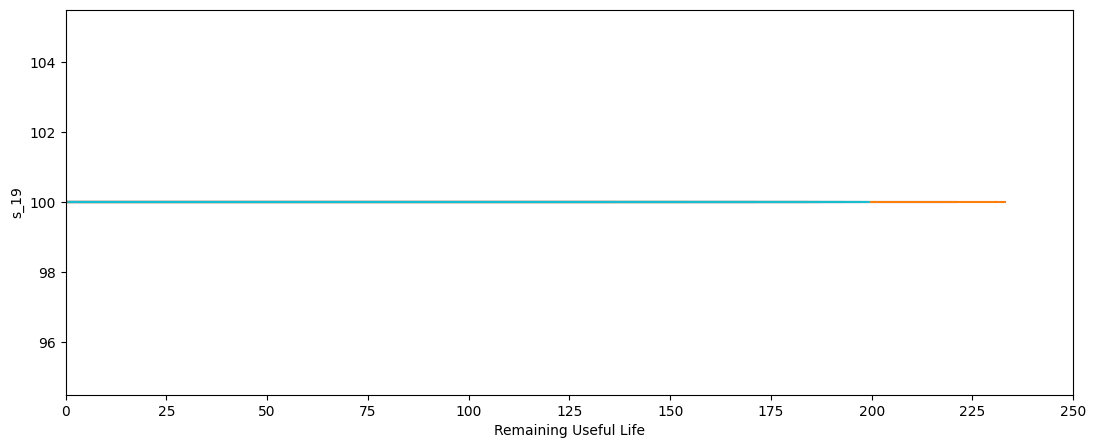

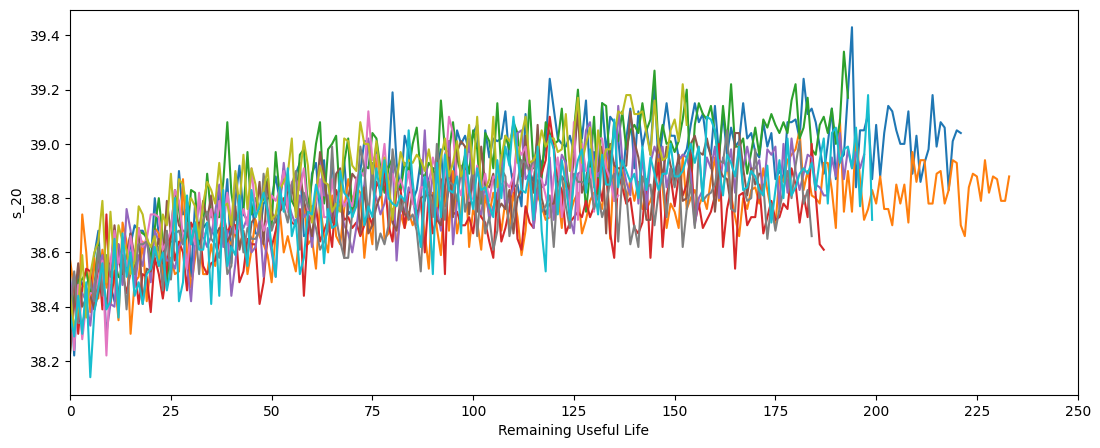

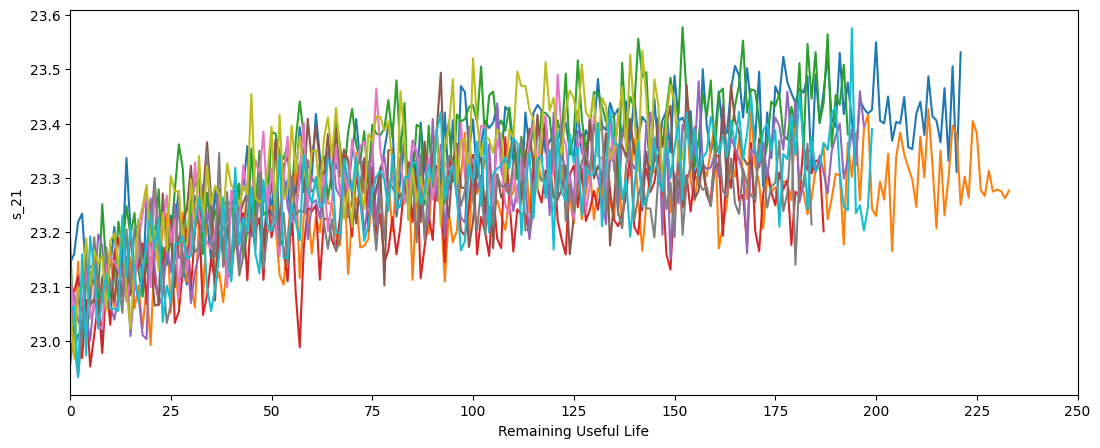

In [ ]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_num'].unique():
        if i % 10 == 0: # Only plot every 10th unit_num
            plt.plot('RUL',sensor_name,data=train[train['unit_num']==i])
    plt.xlim(0,250)
    plt.xticks(np.arange(0,275,25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

*   Based on the plots, we can see that sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
*   Furthermore, we can observe that sensors have strong relation to Remaining Useful Life (RUL) in range from 0 to 125.






# Feature Selection

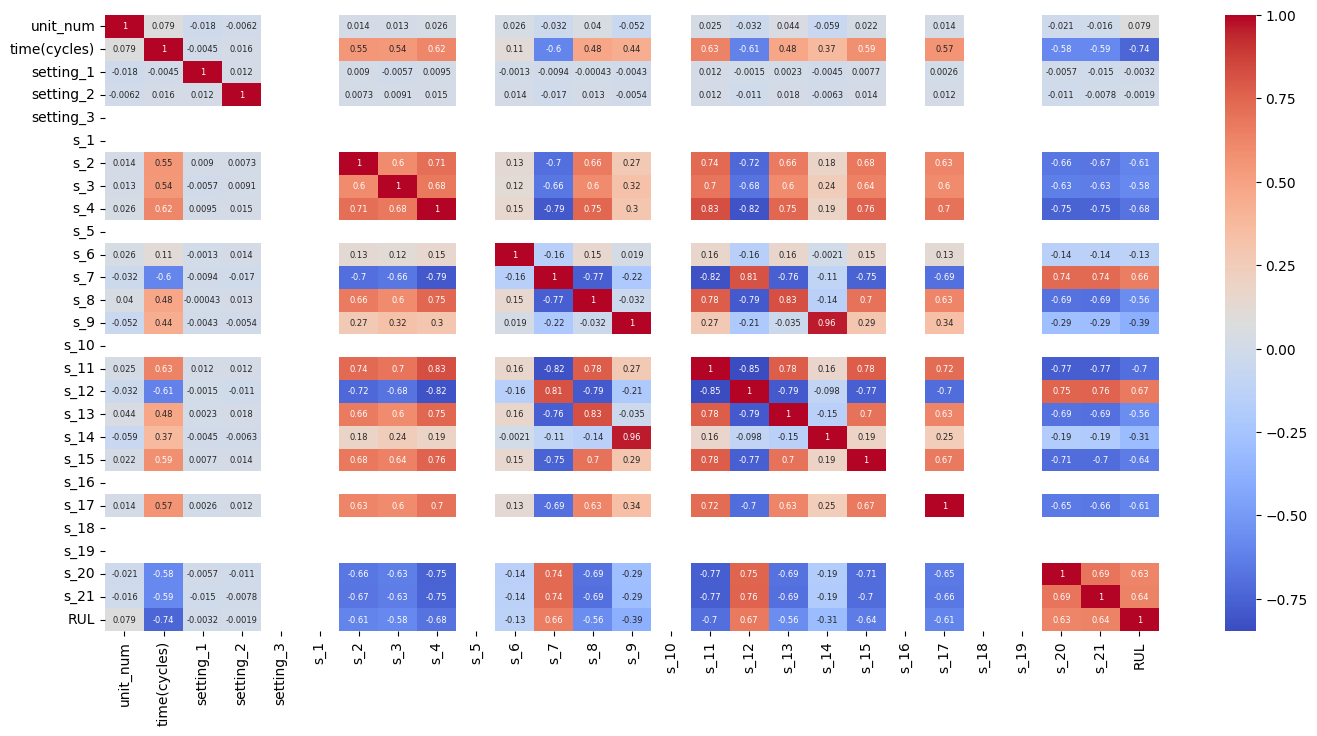

In [ ]:
plt.figure(figsize=(17,8))
sns.heatmap(train.corr(),annot=True,annot_kws={'size': 6},cmap='coolwarm')
plt.show()

We can choose only features that exhibit an absolute correlation value equal to or exceeding 0.5 with the Remaining Useful Life (RUL).

In [ ]:
corr = train.corr()
train_relevant_features = corr[abs(corr['RUL'])>= 0.5]
train_relevant_features['RUL']

time(cycles)   -0.736241
s_2            -0.606484
s_3            -0.584520
s_4            -0.678948
s_7             0.657223
s_8            -0.563968
s_11           -0.696228
s_12            0.671983
s_13           -0.562569
s_15           -0.642667
s_17           -0.606154
s_20            0.629428
s_21            0.635662
RUL             1.000000
Name: RUL, dtype: float64

In [ ]:
relevant_features_list = train_relevant_features.index
relevant_features_list

Index(['time(cycles)', 's_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12',
       's_13', 's_15', 's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [ ]:
relevant_features_list = relevant_features_list[1:]
relevant_features_list

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

The above list contains only those features which have correlation of magnitude greater or equal to 0.5 with Remaining Useful Life (RUL)

In [ ]:
train = train[relevant_features_list]
train.head()

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02  8.4195   
1  642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07  8.4318   
2  642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03  8.4178   
3  642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08  8.3682   
4  642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04  8.4294   

   s_17   s_20     s_21  RUL  
0   392  39.06  23.4190  191  
1   392  39.00  23.4236  190  
2   390  38.95  23.3442  189  
3   392  38.88  23.3739  188  
4   393  38.90  23.4044  187

# Separating features and Target Variable (RUL) from Train Dataset

In [ ]:
X_train = train.drop(['RUL'],axis=1)
y_train = train['RUL']
X_train.shape,y_train.shape

((20631, 12), (20631,))

In [ ]:
X_train.head()

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02  8.4195   
1  642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07  8.4318   
2  642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03  8.4178   
3  642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08  8.3682   
4  642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04  8.4294   

   s_17   s_20     s_21  
0   392  39.06  23.4190  
1   392  39.00  23.4236  
2   390  38.95  23.3442  
3   392  38.88  23.3739  
4   393  38.90  23.4044

In [ ]:
X_train.tail()

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13  \
20626  643.49  1597.98  1428.63  551.43  2388.19  48.07  519.49  2388.26   
20627  643.54  1604.50  1433.58  550.86  2388.23  48.04  519.68  2388.22   
20628  643.42  1602.46  1428.18  550.94  2388.24  48.09  520.01  2388.24   
20629  643.23  1605.26  1426.53  550.68  2388.25  48.39  519.67  2388.23   
20630  643.85  1600.38  1432.14  550.79  2388.26  48.20  519.30  2388.26   

         s_15  s_17   s_20     s_21  
20626  8.4956   397  38.49  22.9735  
20627  8.5139   395  38.30  23.1594  
20628  8.5646   398  38.44  22.9333  
20629  8.5389   395  38.29  23.0640  
20630  8.5036   396  38.37  23.0522

In [ ]:
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [ ]:
test.head()

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0    -0.0006     0.0004      100.0  518.67  642.58  1581.22  1398.91  14.62   
1     0.0018    -0.0001      100.0  518.67  642.55  1586.59  1410.83  14.62   
2    -0.0016     0.0004      100.0  518.67  642.88  1589.75  1418.89  14.62   
3     0.0012     0.0004      100.0  518.67  642.78  1594.53  1406.88  14.62   
4    -0.0013    -0.0004      100.0  518.67  642.27  1589.94  1419.36  14.62   

     s_6     s_7  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0  21.61  554.42  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388   
1  21.61  553.52  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388   
2  21.61  552.59  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388   
3  21.61  552.64  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388   
4  21.61  553.29  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388   

    s_19   s_20     s_21  
0  100.0  38.81  23.3552  
1  100.0  38.81  23.2618  
2  100.0  38.93  23.2740  
3  100.0  38.58  23.2581  
4  100.0  38.75  23.4117  

[5 rows x 24 columns]

In [ ]:
X_test = test[X_train.columns] # Keeping only features in train dataset
X_test.head()

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  642.58  1581.22  1398.91  554.42  2388.08  47.23  521.79  2388.06  8.4024   
1  642.55  1586.59  1410.83  553.52  2388.10  47.67  521.74  2388.09  8.4505   
2  642.88  1589.75  1418.89  552.59  2388.16  47.88  520.83  2388.14  8.4119   
3  642.78  1594.53  1406.88  552.64  2388.13  47.65  521.88  2388.11  8.4634   
4  642.27  1589.94  1419.36  553.29  2388.10  47.46  521.00  2388.15  8.4362   

   s_17   s_20     s_21  
0   393  38.81  23.3552  
1   391  38.81  23.2618  
2   395  38.93  23.2740  
3   395  38.58  23.2581  
4   394  38.75  23.4117

In [ ]:
y_test.head()

RUL
0  112
1   98
2   69
3   82
4   91

Clipping the value of RUL at 125 to improve the performance as we can observe that sensors have strong relation to Remaining Useful Life (RUL) in range from 0 to 125.

In [ ]:
y_train = y_train.clip(upper=125)

# Building and Evaluating Different Models

First step is creating a evaluation function to calculate metrics for regression for the models.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(y_true, y_hat, label = 'test'):
    mse = mean_squared_error(y_true,y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true,y_hat)
    print('{} dataset RMSE:{},R2 Score:{}'.format(label,rmse,r2))
    return rmse,r2

# Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train1 = ss.fit_transform(X_train)
X_test1 = ss.fit_transform(X_test)

StandardScaler is used to standardize the data by shifting it to have a mean of 0 and a standard deviation of 1. This preprocessing step is performed to bring the features to a similar scale, which can help improve the performance of machine learning algorithms.

## Model 1 : Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

logreg = LinearRegression()
logreg.fit(X_train1,y_train)

y_hat_train1 = logreg.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train, y_hat_train1, 'Train')

y_hat_test1 = logreg.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test, y_hat_test1, 'Test')

Train dataset RMSE:22.734164950962253,R2 Score:0.7023848970100307
Test dataset RMSE:25.25194891487648,R2 Score:0.6307417051064357


In [ ]:
Results=pd.DataFrame({'Model':['Linear Regression'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})

## Model 2 : SVM

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train1,y_train)

y_hat_train1 = svr.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train, y_hat_train1, 'Train')

y_hat_test1 = svr.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test, y_hat_test1,'Test')

Train dataset RMSE:21.428640701460495,R2 Score:0.735584932825719
Test dataset RMSE:24.591043283623353,R2 Score:0.6498175601811294


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['SVM'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

## Model 3 : Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 0, max_depth = 15, min_samples_leaf = 10)
dtr.fit(X_train1,y_train)

y_hat_train1 = dtr.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train, y_hat_train1, 'Train')

y_hat_test1 = dtr.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test, y_hat_test1, 'Test')

Train dataset RMSE:17.51183215387695,R2 Score:0.8234124322006571
Test dataset RMSE:24.9902611712588,R2 Score:0.6383553492355616


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['DT'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

## Model 4 : Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state = 0, n_jobs = 1, max_depth = 6, min_samples_leaf = 5)
rfr.fit(X_train1,y_train)

y_hat_train1 = rfr.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train, y_hat_train1, 'Train')

y_hat_test1 = rfr.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test, y_hat_test1, 'Test')

Train dataset RMSE:21.126235922541767,R2 Score:0.7429952182940934
Test dataset RMSE:23.325051890783755,R2 Score:0.6849454957642691


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['Random Forest'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

## Model 5 : Tuned Random Forest

### Hyperparameter tuning using Grid Search

#### Creating a parameter grid

In [ ]:
params = {
    'max_depth':[1,2,5,10,20],
    'min_samples_leaf':[5,10,20,50,100],
    'max_features':[2,3,4,5,6],
    'n_estimators':[10,30,50,100]
}

#### Instantiating and fitting the grid search model

In [ ]:
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(random_state = 0, n_jobs = -1) # use all available cores
grid_search = GridSearchCV(estimator=rfr,param_grid=params,cv=4,n_jobs=-1,verbose=1)
grid_search.fit(X_train1,y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100]},
             verbose=1)

In [ ]:
rfr_best = grid_search.best_estimator_

y_hat_train1 = rfr_best.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train,y_hat_train1,'Train')

y_hat_test1 = rfr_best.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test, y_hat_test1,'Test')

Train dataset RMSE:15.03825201358253,R2 Score:0.869775808434176
Test dataset RMSE:22.380937045245933,R2 Score:0.7099338925051075


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['Tuned RF'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

## Model 6 : XGBoost

In [ ]:
from xgboost import XGBRegressor
xgbr = XGBRegressor(objective = 'reg:linear',n_estimators = 10, seed = 123)
xgbr.fit(X_train1,y_train)

y_hat_train1 = xgbr.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train,y_hat_train1,'Train')

y_hat_test1 = xgbr.predict(X_test1)
RMSE_test, R2_test = evaluate_model(y_test,y_hat_test1,'Test')

[23:29:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Train dataset RMSE:19.642670593349546,R2 Score:0.7778235515573602
Test dataset RMSE:21.54289883667517,R2 Score:0.7312498347951573


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['XgBoost'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

## Model 7 : Artificial Neural Network

In [ ]:
import tensorflow as tf

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=26, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

ann.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

ann.fit(X_train1, y_train, batch_size=10, epochs=100)

Epoch 1/100
2064/2064 [==============================] - 7s 3ms/step - loss: 2273.1814 - mae: 34.1246
Epoch 2/100
2064/2064 [==============================] - 4s 2ms/step - loss: 447.3785 - mae: 16.3967
Epoch 3/100
2064/2064 [==============================] - 5s 2ms/step - loss: 444.2234 - mae: 16.3058
Epoch 4/100
2064/2064 [==============================] - 6s 3ms/step - loss: 442.4210 - mae: 16.2463
Epoch 5/100
2064/2064 [==============================] - 4s 2ms/step - loss: 440.9924 - mae: 16.1953
Epoch 6/100
2064/2064 [==============================] - 4s 2ms/step - loss: 439.2222 - mae: 16.1339
Epoch 7/100
2064/2064 [==============================] - 5s 2ms/step - loss: 437.6993 - mae: 16.0742
Epoch 8/100
2064/2064 [==============================] - 6s 3ms/step - loss: 436.8961 - mae: 16.0459
Epoch 9/100
2064/2064 [==============================] - 4s 2ms/step - loss: 434.8121 - mae: 16.0176
Epoch 10/100
2064/2064 [==============================] - 4s 2ms/step - loss: 431.8135 - m

In [ ]:
y_hat_train1 = ann.predict(X_train1)
RMSE_train, R2_train = evaluate_model(y_train,y_hat_train1,'Train')

y_hat_test1 = ann.predict(X_test1)
RMSE_test,R2_test = evaluate_model(y_test, y_hat_test1,'Test')

645/645 [==============================] - 2s 2ms/step
Train dataset RMSE:20.62176084076344,R2 Score:0.7551227470613655
4/4 [==============================] - 0s 5ms/step
Test dataset RMSE:21.40051152824106,R2 Score:0.7347906908139568


In [ ]:
Results=Results.append(pd.DataFrame({'Model':['ANN'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]}),ignore_index=True)

# Dataframe containing metrics of all models tested

In [ ]:
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  Linear Regression   22.734165  0.702385  25.251949  0.630742
1                SVM   21.428641  0.735585  24.591043  0.649818
2                 DT   17.511832  0.823412  24.990261  0.638355
3      Random Forest   21.126236  0.742995  23.325052  0.684945
4           Tuned RF   15.038252  0.869776  22.380937  0.709934
5            XgBoost   19.642671  0.777824  21.542899  0.731250
6                ANN   20.621761  0.755123  21.400512  0.734791

# Conclusions:
* XGBoost and Artificial Neural Network are providing best results.
